In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Equation: 

# $$ \frac{dx}{dt} = \lambda x$$

# == Setup ==



# Generator (regression):

<img src="generator.png" width="500">

# Discriminator (classification):

<img src="discriminator.png" width="500">

## Analytic Solutionn

In [2]:
L = -1
analytic = lambda t: np.exp(L*t)

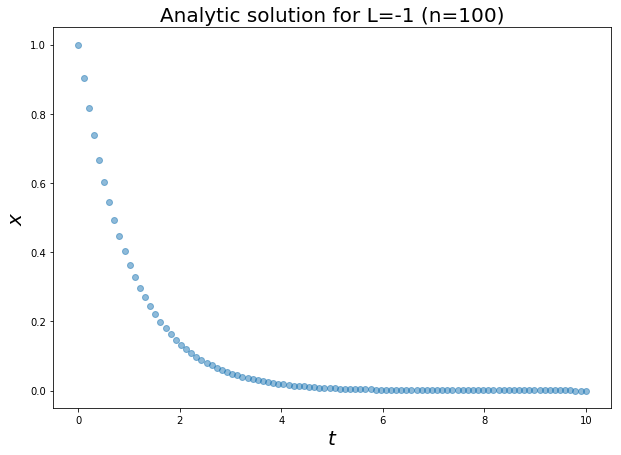

In [3]:
t = np.linspace(0,10,100)
plt.figure(figsize=(10,7))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.plot(t, analytic(t), 'o', alpha=0.5, label='analytic')
plt.title('Analytic solution for L=-1 (n=100)', fontsize=20);

## GAN

In [4]:
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict

In [5]:
class Generator(nn.Module):
    def __init__(self, vec_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(), x0=1):
        super(Generator, self).__init__()
        
        self.x0 = x0
        
        layers = [('lin1', nn.Linear(vec_dim, n_hidden_units)), ('act1', activation)]
        for i in range(n_hidden_layers):
            layer_id = i+2
            layers.append(('lin{}'.format(layer_id), nn.Linear(n_hidden_units, n_hidden_units)))
            layers.append(('act{}'.format(layer_id), activation))
        layers.append(('linout', nn.Linear(n_hidden_units, vec_dim)))
        layers.append(('actout', nn.Tanh()))
        
        layers = OrderedDict(layers)
        self.main = nn.Sequential(layers)
    
    def forward(self, x):
        output = self.main(x)
        return output
    
    def predict(self, t):
        x_pred = self(t)
        x_adj = self.x0 + (1 - torch.exp(-t)) * x_pred
        return x_adj

class Discriminator(nn.Module):
    def __init__(self, vec_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh()):
        super(Discriminator, self).__init__()
        
        layers = [('lin1', nn.Linear(vec_dim, n_hidden_units)), ('act1', activation)]
        for i in range(n_hidden_layers):
            layer_id = i+2
            layers.append(('lin{}'.format(layer_id), nn.Linear(n_hidden_units, n_hidden_units)))
            layers.append(('act{}'.format(layer_id), activation))
        layers.append(('linout', nn.Linear(n_hidden_units, vec_dim)))
        layers.append(('actout', nn.Sigmoid()))
        
        layers = OrderedDict(layers)
        self.main = nn.Sequential(layers)
    
    def forward(self, x):
        output = self.main(x)
        return output

In [6]:
def plot_loss(G_loss, D_loss, ax):
    epochs=np.arange(len(G_loss))
    ax.plot(epochs, np.log(G_loss), label='G Loss')
    ax.plot(epochs, np.log(D_loss), label='D Loss')
    ax.set_title('Loss of D and G')
    ax.set_xlabel('epoch')
    ax.set_ylabel('log-loss')
    ax.legend()

def plot_preds(G, t, analytic, ax):
    ax.plot(t, analytic(t), label='analytic')
    t_torch = tensor(t, dtype=torch.float, requires_grad=True).reshape(-1,1)
    pred = G.predict(t_torch)
    ax.plot(t, pred.detach().numpy().flatten(), '--', label='pred')
    ax.set_title('Pred and Analytic')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.legend()

def plot_losses_and_preds(G_loss, D_loss, G, t, analytic, figsize=(15,5)):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    plot_loss(G_loss, D_loss, ax[0])
    plot_preds(G, t, analytic, ax[1])
    plt.show()

In [21]:
def train_Lagaris(num_epochs, 
                  L=-1, 
                  g_hidden_units=10, 
                  g_hidden_layers=2, 
                  g_lr=0.001,
                  t_low=0, 
                  t_high=10, 
                  G_iters=1,
                  n=100):
    """
    function to perform Lagaris-style training
    """
    
    # initialize net
    G = Generator(vec_dim=1, 
                  n_hidden_units=g_hidden_units, 
                  n_hidden_layers=g_hidden_layers,
                  activation=nn.LeakyReLU())
    
    # grid
    t = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    
    # perturb grid
    delta_t = t[1]-t[0]
    def get_batch():
        return t + delta_t * torch.randn_like(t) / 3
    
    mse = nn.MSELoss()
    optiG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.9, 0.999))
    
    # logging
    D_losses = []
    G_losses = []

    for epoch in range(num_epochs):
        
        t = get_batch() 
        
        for i in range(G_iters):

            x_pred = G.predict(t)
            lam_x = L * x_pred

            # compute dx/dt
            dx_dt, = autograd.grad(x_pred, t, 
                                  grad_outputs=lam_x.data.new(lam_x.shape).fill_(1), 
                                  create_graph=True)

            optiG.zero_grad()
            g_loss = mse(lam_x, dx_dt)
            g_loss.backward(retain_graph=True)
            optiG.step()

        G_losses.append(g_loss.item())
        
    return G, G_losses

In [8]:
def train_GAN(num_epochs, 
          L=-1, 
          g_hidden_units=10, 
          d_hidden_units=10, 
          g_hidden_layers=2, 
          d_hidden_layers=2, 
          d_lr=0.001,
          g_lr=0.001,
          t_low=0, 
          t_high=10, 
          n=100, 
          real_label=1, 
          fake_label=0, 
          logging=True, 
          G_iters=1, 
          D_iters=1):
    
    """
    function to perform training of generator and discriminator for num_epochs
    """
    
    # initialize nets
    G = Generator(vec_dim=1, 
                  n_hidden_units=g_hidden_units, 
                  n_hidden_layers=g_hidden_layers,
                  activation=nn.LeakyReLU())
    
    D = Discriminator(vec_dim=1, 
                      n_hidden_units=d_hidden_units, 
                      n_hidden_layers=d_hidden_layers,
                      activation=nn.LeakyReLU())
    
    # grid
    t = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    
    # perturb grid
    delta_t = t[1]-t[0]
    def get_batch():
        return t + delta_t * torch.randn_like(t) / 3
    
    # labels
    real_label_vec = torch.full((n,), real_label).reshape(-1,1)
    fake_label_vec = torch.full((n,), fake_label).reshape(-1,1)
    
    # optimization
    cross_entropy = nn.BCELoss()
    mse = nn.MSELoss()
    wass_loss = lambda y_true, y_pred: torch.mean(y_true * y_pred)
    optiD = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.9, 0.999))
    optiG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.9, 0.999))
    
    # logging
    D_losses = []
    G_losses = []

    for epoch in range(num_epochs):

        ## =========
        ##  TRAIN G
        ## =========
        
        t = get_batch() 
        
        for i in range(G_iters):

            x_pred = G.predict(t)
            real = L * x_pred

            # compute dx/dt
            fake, = autograd.grad(x_pred, t, 
                                  grad_outputs=real.data.new(real.shape).fill_(1), 
                                  create_graph=True)
            
            optiG.zero_grad()
            g_loss = cross_entropy(D(fake), real_label_vec)
            g_loss.backward(retain_graph=True)
            optiG.step()
        
        ## =========
        ##  TRAIN D
        ## ========= 

        for i in range(D_iters):

            real_loss = cross_entropy(D(real), real_label_vec)
            fake_loss = cross_entropy(D(fake), fake_label_vec)

            optiD.zero_grad()
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward(retain_graph=True)
            optiD.step()

        ## ========
        ## Logging
        ## ========
        
        if logging:
            print('[%d/%d] D_Loss : %.4f Loss_G: %.4f' % (epoch, num_epochs, d_loss.item(), g_loss.item()))
        
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        
    return G, D, G_losses, D_losses

## GAN Training

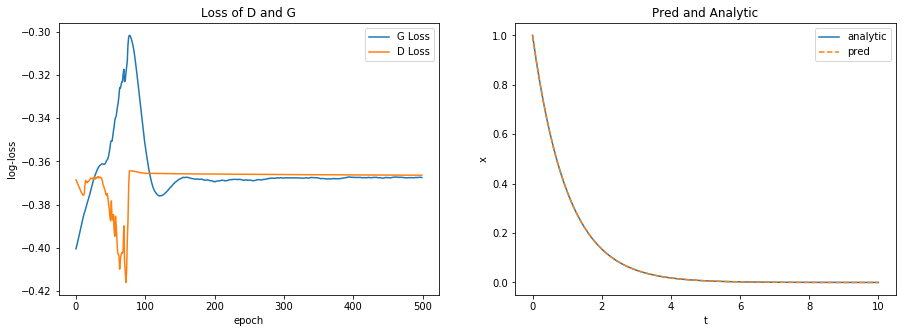

CPU times: user 24.5 s, sys: 140 ms, total: 24.7 s
Wall time: 24.7 s


In [17]:
%%time
G,D,G_loss,D_loss = train_GAN(500, 
                              g_hidden_units=20, 
                              g_hidden_layers=3,
                              d_hidden_units=10, 
                              d_hidden_layers=2,
                              logging=False, 
                              G_iters=10, 
                              D_iters=1, 
                              n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

## Lagaris Training

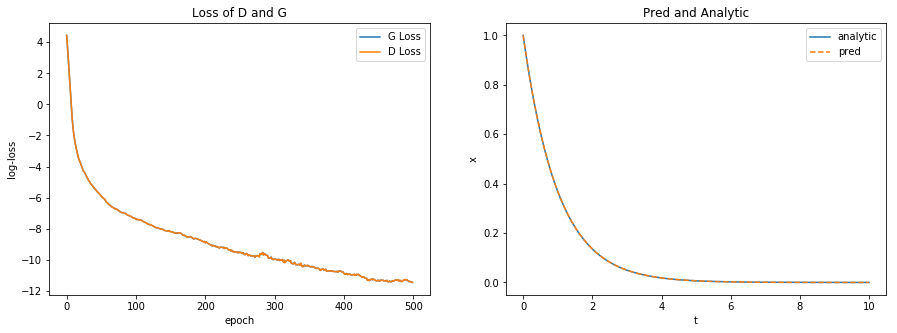

CPU times: user 21.7 s, sys: 122 ms, total: 21.8 s
Wall time: 21.8 s


In [22]:
%%time
F,F_loss = train_Lagaris(500, 
                         g_hidden_units=20, 
                         g_hidden_layers=3,
                         G_iters=10,
                         n=100)
plot_losses_and_preds(F_loss, F_loss, F, t, analytic)

## Compare MSE (pred vs. actual)

In [24]:
t_torch = tensor(t, dtype=torch.float, requires_grad=True).reshape(-1,1)
gan_pred = G.predict(t_torch)
lag_pred = F.predict(t_torch)

In [27]:
actual = tensor(analytic(t), dtype=torch.float).reshape(-1,1)

In [28]:
mse = nn.MSELoss()
gan_mse = mse(gan_pred, actual)
lag_mse = mse(lag_pred, actual)

In [29]:
print('GAN MSE: {}'.format(gan_mse))
print('Lagaris MSE: {}'.format(lag_mse))

GAN MSE: 1.0749186913835973e-12
Lagaris MSE: 7.31833083023048e-08
